In [1]:
# setup
import numpy as np
import scipy
import scipy.spatial
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize
nr_sets = 5


In [2]:
def simplices2poly(simplices):
    poly = [int(simplices[0][0])]
    edges = set([(i, j) for i, j in simplices])
    while len(edges):
        #print(poly, edges)
        next_edge = None
        next_val = None
        for edge in edges:
            i, j = edge
            if i == poly[-1]:
                next_edge = (i, j)
                next_val = j
                break
            if j == poly[-1]:
                next_edge = (i, j)
                next_val = i
                break
        edges.remove(next_edge)
        poly.append(next_val)
    return poly

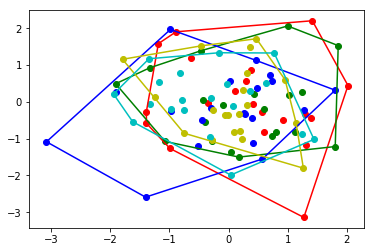

In [170]:
colors = 'rgbyc'
# show C_i
C = [None] * nr_sets
nr_point_dim = 2
for idx_set in range(nr_sets):
    points = np.random.randn(20, nr_point_dim)
    hull = scipy.spatial.ConvexHull(points)
    plt.scatter(points[:, 0], points[:, 1], c=colors[idx_set])
    poly = simplices2poly(hull.simplices)
    plt.plot(points[poly, 0], points[poly, 1], c=colors[idx_set])
    C[idx_set] = (points[poly], points)

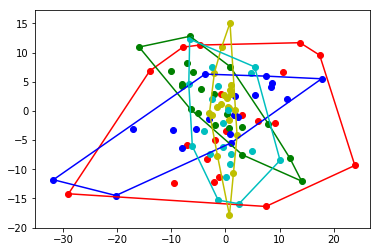

In [210]:
# generate X_i
X = np.zeros((nr_sets, nr_point_dim, nr_point_dim), dtype=np.float32)
for idx_set in range(nr_sets):
    X[idx_set] = np.eye(nr_point_dim)+np.random.randn(nr_point_dim, nr_point_dim)*5

# show D_i
D = [None]*nr_sets
for idx_set in range(nr_sets):
    points_poly, points = C[idx_set]
    points_poly = np.einsum('ij,nj->ni', X[idx_set].T, points_poly)
    points = np.einsum('ij,nj->ni', X[idx_set].T, points)
    D[idx_set] = (points_poly, points)
    plt.scatter(points[:, 0], points[:, 1], c=colors[idx_set])
    plt.plot(points_poly[:, 0], points_poly[:, 1], c=colors[idx_set])

In [248]:
# implement projection
def PC(point, c_i):
    points_hull, _ = c_i
    projection = cp.Variable(nr_point_dim)
    objective = cp.Minimize(cp.sum_squares(point-projection))
    centroid = points_hull.mean(axis=0)
    centroid = np.array([centroid[0], centroid[1], 1])
    
    constraints = []
    for i in range(len(points_hull)-1):
        p1 = points_hull[i]
        p2 = points_hull[i+1]
        line = scipy.linalg.null_space([[p1[0],p1[1],1], [p2[0],p2[1],1]])[:,0]
        # print(line, centroid)
        if line@centroid > 0:
            constraints.append(projection@line[:2]+line[2]>=0)
        else:
            constraints.append(projection@line[:2]+line[2]<=0)
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=False)
    return projection.value


In [242]:
# implement coordinate descent
import cvxpy as cp
def optimize_wi(w_k_prev, w_k_next, i):
    residual =  y - np.einsum('nij,nj->i', X[i+1:], w_k_prev[i+1:]) - np.einsum('nij,nj->i', X[:i], w_k_next[:i])
    w_i = cp.Variable(nr_point_dim)
    objective = cp.Minimize(cp.sum_squares(residual-X[i]@w_i)/2+cp.max(D[i][0]@w_i))
    prob = cp.Problem(objective)
    result = prob.solve(verbose=False)
    return w_i.value

In [233]:
# to check 4(b) is valid
y = np.random.randn(nr_point_dim) * 50
print(y)
projection = PC(y, C[0])
print(projection)
print(y-X[0]@optimize_wi(w_prev, w_next, 0))

[  9.58282254 -10.94796509]
WARN: aa_init returned NULL, no acceleration applied.
[ 1.27490485 -3.14041102]
WARN: aa_init returned NULL, no acceleration applied.
[ 1.27512993 -3.1406217 ]


# primal coordinate descent

\begin{equation}
\min_{w \in R^p} \; \frac{1}{2} \|y - Xw\|_2^2 + 
\sum_{i=1}^d h_i(w_i), 
\end{equation}
\begin{equation}
w_i^{(k)} = \arg \min_{w_i \in R^{p_i}} \; \frac{1}{2} \bigg\| y - \sum_{j<i}
X_j w_j^{(k)} - \sum_{j>i} X_j w_j^{(k-1)} - X_iw_i \bigg\|_2^2 + h_i(w_i),
\quad i=1,\ldots,d, 
\end{equation}

In [243]:
def hi(w_i, d_i):
    points_poly, _ = d_i
    return np.max(points_poly@w_i)

def wi_criterion(w_i, w_k_prev, w_k_next, i):
    val_hi = hi(w_i, D[i])
    err = y - np.einsum('nij,nj->i', X[i+1:], w_k_prev[i+1:]) - np.einsum('nij,nj->i', X[:i], w_k_next[:i]) - X[i]@w_i
    # print(w_i, val_hi, np.sum(err*err))
    return 0.5 * np.sum(err*err) + val_hi

In [244]:
def f(w_i, w_k_prev, w_k_next, i):
    return wi_criterion(w_i, w_k_prev, w_k_next, i) + sum([hi(w_k_next[j], D[j]) for j in range(i)]) + sum([hi(w_k_prev[j], D[j]) for j in range(i+1, nr_sets)])

In [245]:
nr_outer_iter = 20
w_primal = np.zeros((nr_outer_iter+1, nr_sets, nr_point_dim))
for idx_outer_iter in range(nr_outer_iter):
    for idx_inner_iter in range(nr_sets):
        w_primal[idx_outer_iter+1, idx_inner_iter] = optimize_wi(w_primal[idx_outer_iter], w_primal[idx_outer_iter+1], idx_inner_iter)
        # print(idx_outer_iter, idx_inner_iter, f(w_primal[idx_outer_iter+1, idx_inner_iter], w_primal[idx_outer_iter], w_primal[idx_outer_iter+1], idx_inner_iter))

Text(0.5, 1.0, 'Primal Proximal coordinate descent')

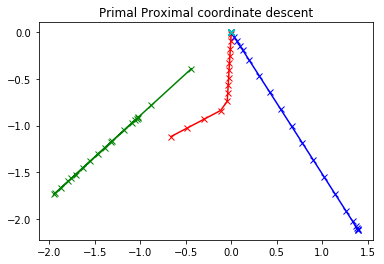

In [253]:
for i in range(nr_sets):
    plt.plot(w_primal[1:, i,0], w_primal[1:, i, 1], c=colors[i], marker='x')
plt.title('$w$ of Primal Proximal coordinate descent')

# Dual dykstra
\begin{align*}
u_0^{(k)} &= u_d^{(k-1)}, \\
u_i^{(k)} &= P_{C_i} (u_{i-1}^{(k)} + z_i^{(k-1)}),\\
z_i^{(k)} &= u_{i-1}^{(k)} + z_i^{(k-1)} - u_i^{(k)},
\end{align*}

In [249]:
u_dual = np.zeros((nr_outer_iter+1, nr_sets+1, nr_point_dim))
z_dual = np.zeros((nr_outer_iter+1, nr_sets+1, nr_point_dim))
u_dual[0, nr_sets] = y

for idx_outer_iter in range(1, nr_outer_iter+1):
    u_dual[idx_outer_iter, 0] = u_dual[idx_outer_iter-1, nr_sets] 
    for idx_inner_iter in range(1, nr_sets+1):
        u = u_dual[idx_outer_iter, idx_inner_iter-1]
        z = z_dual[idx_outer_iter-1, idx_inner_iter]
        s = u + z
        proj = PC(s, C[idx_inner_iter-1])
        u_dual[idx_outer_iter, idx_inner_iter] = proj
        z_dual[idx_outer_iter, idx_inner_iter] = s - proj
        # print(u, z, s, proj, np.linalg.inv(X[idx_inner_iter-1])@(s - proj))


Text(0.5, 1.0, '$X^{-1}u$ of Dual Dykstra')

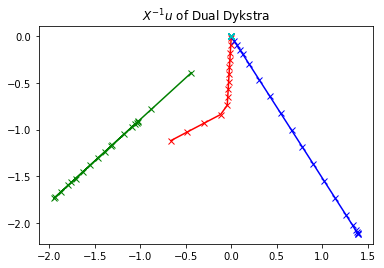

In [255]:
for i in range(nr_sets):
    w = np.einsum('ij,nj->ni',np.linalg.inv(X[i]),z_dual[:,i+1])
    plt.plot(w[1:,0], w[1:,1], c=colors[i], marker='x')
plt.title('$X^{-1}u$ of Dual Dykstra')